In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

# Step 1: Build the Custom DataLoader for KITTI Road Segmentation dataset

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


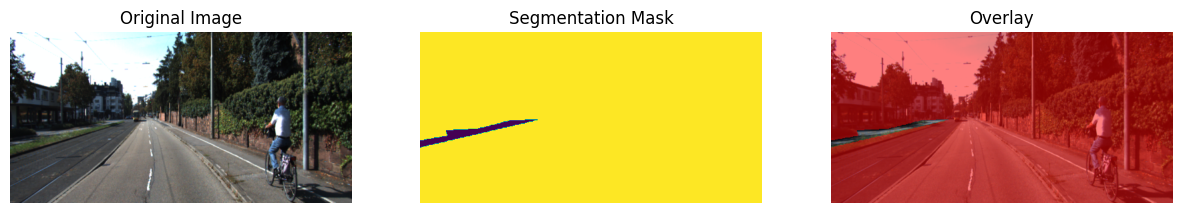

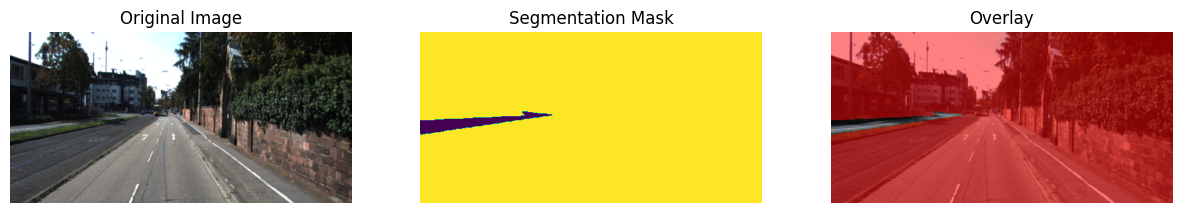

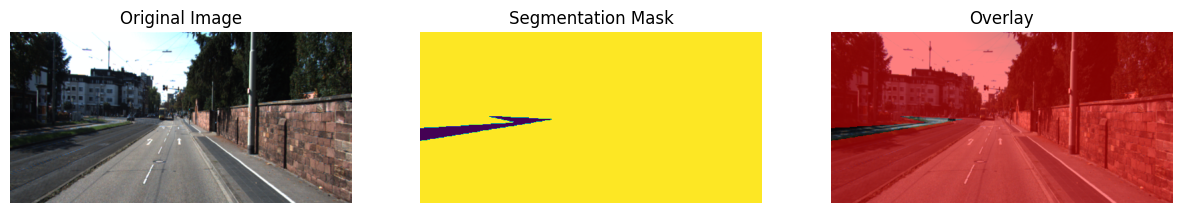

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Step 1: Build the Custom DataLoader for KITTI Road Segmentation Dataset
class KittiRoadDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Directory with the KITTI dataset.
            mode (string): 'train' or 'test'. In train mode both image and ground truth mask
                           are returned. In test mode only the image (and its filename) is returned.
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.mask_transform = mask_transform

        if mode == 'train':
            self.img_dir = os.path.join(root_dir, 'training', 'image_2')
            self.mask_dir = os.path.join(root_dir, 'training', 'gt_image_2')
        elif mode == 'test':
            # According to the description, the test images are inside: testing/image_2
            self.img_dir = os.path.join(root_dir, 'testing', 'image_2')
            self.mask_dir = None
        else:
            raise ValueError("mode should be either 'train' or 'test'")

        self.img_files = sorted(os.listdir(self.img_dir))
        if mode == 'train':
            self.mask_files = sorted(os.listdir(self.mask_dir))
        else:
            self.mask_files = None

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.mode == 'train':
            # Load corresponding mask.
            mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
            mask = Image.open(mask_path).convert('L')  # Grayscale; nonzero values indicate road.
            # Convert mask to binary: road pixels = 1, background = 0.
            mask_np = np.array(mask)
            mask_np = (mask_np > 0).astype(np.uint8)
            mask = Image.fromarray(mask_np)
            if self.mask_transform:
                mask = self.mask_transform(mask)
            else:
                # If no transform is provided, convert to tensor (as LongTensor for loss)
                mask = torch.from_numpy(np.array(mask)).long()
            return image, mask
        else:
            # In test mode, return image and its filename.
            return image, self.img_files[idx]

# Helper function to convert mask image to tensor.
def mask_to_tensor(img):
    return torch.from_numpy(np.array(img)).long()

# Updated transforms for masks using the helper function.
mask_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=Image.NEAREST),
    transforms.Lambda(mask_to_tensor)
])

# Image transforms for training and testing.
train_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set the root directory of your KITTI dataset (update this path accordingly)
dataset_root = r'/content/drive/MyDrive/ATDL_Assignment03/data_road/data_road'  # Change this to your dataset path

# Create training and test datasets and dataloaders.
train_dataset = KittiRoadDataset(root_dir=dataset_root, mode='train',
                                 transform=train_transform, mask_transform=mask_transform)
test_dataset = KittiRoadDataset(root_dir=dataset_root, mode='test',
                                transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Updated visualization function to display original image, mask, and overlay.
def visualize_samples(dataset, num_samples=3):
    """Display a few samples from the dataset with an overlay of the segmentation mask."""
    for i in range(num_samples):
        image, mask = dataset[i]

        # Convert image tensor (C, H, W) to a NumPy array (H, W, C) and de-normalize.
        image_np = image.numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image_np = np.clip(image_np, 0, 1)

        # Convert mask tensor to NumPy array.
        mask_np = mask.numpy()

        # Create an overlay: highlight road pixels (mask == 1) in red.
        overlay = image_np.copy()
        # Define the color for road (red) and the transparency factor.
        road_color = np.array([1, 0, 0])  # Red in normalized RGB.
        alpha = 0.5  # Transparency factor.
        # For each pixel where mask==1, blend the original image with the red color.
        overlay[mask_np == 1] = (1 - alpha) * overlay[mask_np == 1] + alpha * road_color

        # Plot the original image, the binary mask (with a colormap), and the overlay.
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        # Using a colormap like 'viridis' to better highlight differences.
        plt.imshow(mask_np, cmap='viridis')
        plt.title('Segmentation Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Overlay')
        plt.axis('off')

        plt.show()

# Visualize a few training samples.
visualize_samples(train_dataset, num_samples=3)


# Step 2: Load the Pretrained DeepLabV3 MobileNet Model and Fine Tune

In [14]:
# Use the torchvision implementation of DeepLabV3 with MobileNet backbone.
# (See also the reference repository: https://github.com/leimao/DeepLab-V3)
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)

# Modify the classifier head to output 2 classes: background and road.
num_classes = 2
# The classifier is typically a small sequential module.
# Replace the final convolution layer. (Here model.classifier[4] is the last Conv2d layer.)
in_channels = model.classifier[4].in_channels
model.classifier[4] = nn.Conv2d(in_channels, num_classes, kernel_size=1)

# Send model to GPU if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Step 3: Train the Model and Plot Loss vs. Epoch

Starting training...
Epoch [1/20], Loss: 0.0647
Epoch [2/20], Loss: 0.0522
Epoch [3/20], Loss: 0.0440
Epoch [4/20], Loss: 0.0376
Epoch [5/20], Loss: 0.0315
Epoch [6/20], Loss: 0.0283
Epoch [7/20], Loss: 0.0266
Epoch [8/20], Loss: 0.0248
Epoch [9/20], Loss: 0.0217
Epoch [10/20], Loss: 0.0196
Epoch [11/20], Loss: 0.0187
Epoch [12/20], Loss: 0.0193
Epoch [13/20], Loss: 0.0174
Epoch [14/20], Loss: 0.0179
Epoch [15/20], Loss: 0.0178
Epoch [16/20], Loss: 0.0165
Epoch [17/20], Loss: 0.0146
Epoch [18/20], Loss: 0.0138
Epoch [19/20], Loss: 0.0145
Epoch [20/20], Loss: 0.0142


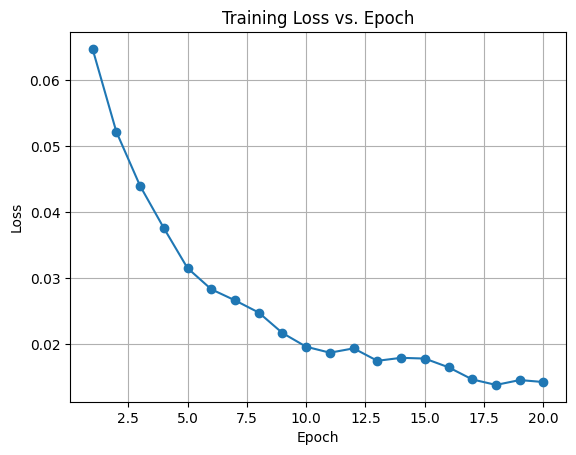

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assume model, train_loader, device, etc., are already defined.

# Define a custom function to set training mode while keeping BatchNorm layers frozen.
def set_trainable(model, train_bn=False):
    model.train()  # Put model in train mode.
    if not train_bn:
        for m in model.modules():
            if isinstance(m, torch.nn.BatchNorm2d):
                m.eval()  # Freeze BN layers.

# Set up optimizer and loss criterion.
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()  # Expects targets as LongTensor

# Training Loop.
num_epochs = 20
train_losses = []

print("Starting training...")

for epoch in range(num_epochs):
    # Set model to train mode but keep BN layers frozen.
    set_trainable(model, train_bn=False)

    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        # DeepLabV3 returns a dict; the segmentation output is in key 'out'
        outputs = model(images)['out']  # shape: [N, num_classes, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Plot Loss vs. Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.show()

# Step 4: Evaluate the Model with Metrics and Generate Test Segmentations


In [18]:
def compute_metrics(pred, target, num_classes=2):
    """
    Compute Intersection over Union (IoU) for each class, pixel accuracy,
    and per-class pixel accuracy.
    Args:
        pred (torch.Tensor): predicted mask (H, W), type LongTensor.
        target (torch.Tensor): ground truth mask (H, W), type LongTensor.
        num_classes (int): number of classes.
    Returns:
        ious (list): IoU for each class.
        mean_iou (float): Mean IoU.
        pixel_accuracy (float): Overall pixel accuracy.
        mean_pixel_accuracy (float): Mean per-class pixel accuracy.
    """
    ious = []
    # Overall pixel accuracy.
    pixel_accuracy = (pred == target).sum().item() / (target.numel())
    # Compute per-class IoU.
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        ious.append(iou)
    mean_iou = np.nanmean(ious)

    # Compute per-class pixel accuracy and then average.
    class_accuracies = []
    for cls in range(num_classes):
        target_inds = (target == cls)
        if target_inds.sum().item() == 0:
            class_acc = float('nan')
        else:
            class_acc = ((pred == cls) & target_inds).sum().item() / target_inds.sum().item()
        class_accuracies.append(class_acc)
    mean_pixel_accuracy = np.nanmean(class_accuracies)
    return ious, mean_iou, pixel_accuracy, mean_pixel_accuracy


# For demonstration, we evaluate on the training set.
model.eval()
all_ious = []
all_mean_iou = []
all_pixel_acc = []
all_mean_pixel_acc = []

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)  # (N, H, W)
        for pred, mask in zip(preds, masks):
            ious, mean_iou, pixel_acc, mean_pix_acc = compute_metrics(pred.cpu(), mask.cpu(), num_classes)
            all_ious.append(ious)
            all_mean_iou.append(mean_iou)
            all_pixel_acc.append(pixel_acc)
            all_mean_pixel_acc.append(mean_pix_acc)

# Compute average metrics over the dataset.
avg_ious = np.nanmean(all_ious, axis=0)
avg_mean_iou = np.nanmean(all_mean_iou)
avg_pixel_acc = np.mean(all_pixel_acc)
avg_mean_pixel_acc = np.nanmean(all_mean_pixel_acc)

print("\nEvaluation Metrics on Training Set:")
for cls in range(num_classes):
    print(f"Class {cls} IoU: {avg_ious[cls]:.4f}")
print(f"Mean IoU: {avg_mean_iou:.4f}")
print(f"Pixel Accuracy: {avg_pixel_acc:.4f}")
print(f"Mean Pixel Accuracy: {avg_mean_pixel_acc:.4f}")


# Generate segmentation results for test images.
# The segmentation outputs are saved in the folder "test_results".
output_dir = '/content/drive/MyDrive/ATDL_Assignment03/test_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("\nPerforming inference on test images and saving outputs...")
model.eval()
with torch.no_grad():
    for image, filename in test_loader:
        image = image.to(device)
        output = model(image)['out']
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()  # (H, W)
        # Save the predicted mask. Multiply by 255 so that road=255 and background=0.
        pred_img = Image.fromarray((pred * 255).astype(np.uint8))
        save_path = os.path.join(output_dir, filename[0])
        pred_img.save(save_path)
        print(f"Saved segmentation result for {filename[0]}")

print("\nAll processing complete.")



Evaluation Metrics on Training Set:
Class 0 IoU: 0.5848
Class 1 IoU: 0.9935
Mean IoU: 0.8545
Pixel Accuracy: 0.9937
Mean Pixel Accuracy: 0.8943

Performing inference on test images and saving outputs...
Saved segmentation result for um_000000.png
Saved segmentation result for um_000001.png
Saved segmentation result for um_000002.png
Saved segmentation result for um_000003.png
Saved segmentation result for um_000004.png
Saved segmentation result for um_000005.png
Saved segmentation result for um_000006.png
Saved segmentation result for um_000007.png
Saved segmentation result for um_000008.png
Saved segmentation result for um_000009.png
Saved segmentation result for um_000010.png
Saved segmentation result for um_000011.png
Saved segmentation result for um_000012.png
Saved segmentation result for um_000013.png
Saved segmentation result for um_000014.png
Saved segmentation result for um_000015.png
Saved segmentation result for um_000016.png
Saved segmentation result for um_000017.png
Save